In [1]:
import wandb

In [2]:
api = wandb.Api()

In [251]:
runs = list(api.runs('gnn_tracking/gnn_tracking_gc', ))
runs.extend(list(api.runs('gnn_tracking/mdmm', )))

In [252]:
import math

runs = sorted(runs, key=lambda run: float(run.summary.get("n_edges_frac_segment50_95", math.inf)), reverse=False)

In [253]:
selected_runs = list(runs[:5])

In [254]:
runs2losses = {
    r: {
        "attractive": r.summary.get("attractive", math.inf),
        "repulsive": r.summary.get("repulsive", math.inf),
    }
    for r in runs
}

In [255]:

runs2losses = {
    k: v for k, v in runs2losses.items() if v["attractive"] < math.inf and v["repulsive"] < math.inf
}

In [256]:
r = selected_runs[0]

import numpy as np


def find_pareto_front(xs: np.ndarray, ys: np.ndarray):
    pareto_optimal = []
    ep = np.stack((xs, ys))
    for (x, y) in zip(xs, ys):
        n_opt = (np.array((x, y)).reshape((2, 1)) < ep).sum(axis=0) == 2
        if  n_opt.any():
            pareto_optimal.append(False)
            continue
        pareto_optimal.append(True)
    return np.array(pareto_optimal)

In [257]:
_as = np.array([v["attractive"] for v in runs2losses.values()])
_bs = np.array([v["repulsive"] for v in runs2losses.values()])

In [258]:
pareto_mask = find_pareto_front(_as, _bs)

In [259]:
len(pareto_mask)

34

In [260]:
pareto_mask.sum()

2

In [277]:
from matplotlib import pyplot as plt

class LossHistoryPlot:
    def __init__(self, *, ax=None, x_loss="attractive", y_loss="repulsive", smooth_window=0):
        self.x_loss = x_loss
        self.y_loss = y_loss
        self.ax = ax
        self.smooth_window = smooth_window
        if ax is None:
            _, self.ax = plt.subplots()
        self.ax.set_xlabel(x_loss)
        self.ax.set_ylabel(y_loss)

    def get_label(self, run):
        lw = run.config["lw_repulsive"]
        return r"$w_{\mathrm{rep}} = " + f"{lw}" + r"$"

    def add_run(self, run, *, start_epoch=0):
        _history = run.history(samples=int(1e6))
        history = _history[_history.epoch >= start_epoch][[self.x_loss, self.y_loss]].dropna()
        if self.smooth_window:
            history = history.rolling(self.smooth_window, center=True).mean().dropna()
        line, *_ = self.ax.plot(self.x_loss, self.y_loss, data=history, alpha=0.5, label="_")
        color = line.get_color()
        self.ax.scatter(self.x_loss, self.y_loss, data=history.tail(n=1), marker="o", color=color, s=30, label=self.get_label(r))

    def add_runs(self, runs, *args, **kwargs):
        for run in runs:
            self.add_run(run, *args, **kwargs)


    def add_legend(self):
        self.ax.legend()


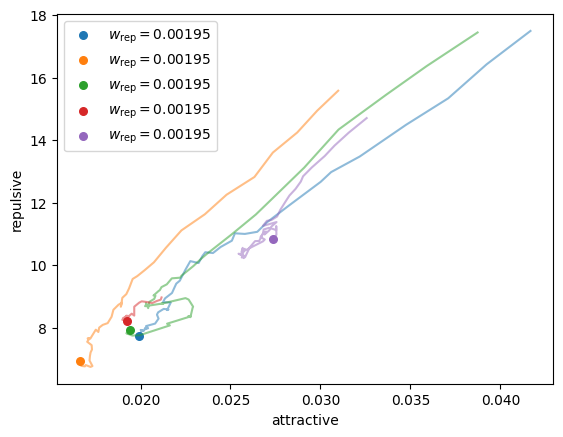

In [278]:
lhp =  LossHistoryPlot(smooth_window=9)
lhp.add_runs(selected_runs, start_epoch=5)
lhp.add_legend()

In [263]:
class FOMHistoryPlot:
    def __init__(self, run, *, ax=None):
        self.history = run.history(samples=int(1e6))
        self.ax = ax
        if ax is None:
            _, self.ax = plt.subplots()
        self.ax.set_xlabel("epoch")

    def add_fom(self, fom: str, *, label=""):
        if not label:
            label = fom
        self.ax.plot("epoch", fom, data=self.history.dropna(subset=[fom]), label=label)

    def add_foms(self, foms: list[str], *, labels: list[str] = None):
        if labels is None:
            labels = [None for _ in foms]
        for fom, label in zip(foms, labels):
            self.add_fom(fom)

    def add_legend(self):
        self.ax.legend()

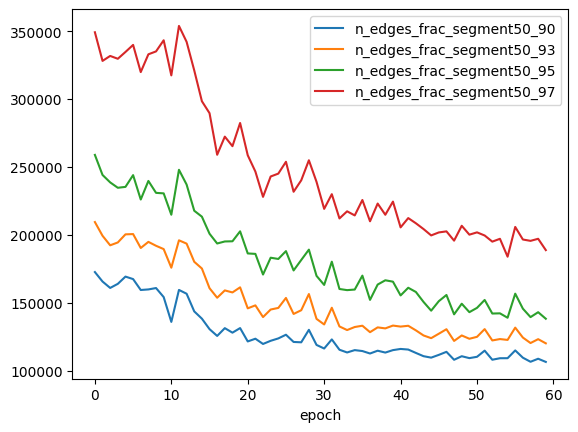

In [264]:
fhp = FOMHistoryPlot(r)
fhp.add_foms([f"n_edges_frac_segment50_{x}".format(x) for x in [90, 93, 95, 97]])
fhp.add_legend()